<a href="https://colab.research.google.com/github/prashant-gulati/pytorch/blob/main/pytorch_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 230kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.30MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.2MB/s]


In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")


    print(f"Len of train_data_loader: {len(train_dataloader)}")
    print(f"Len of test_data_loader: {len(test_dataloader)}")

    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Len of train_data_loader: 938
Len of test_data_loader: 157


In [5]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    #print(f"size: {size}");
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    #print(f"size: {size}");
    #print(f"num_batches: {num_batches}");
    model.eval()
    test_loss, correct = 0, 0
    #counter = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            #counter += 1
            #print(f"counter: {counter}");
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.304222  [   64/60000]
loss: 2.167125  [ 6464/60000]
loss: 1.787594  [12864/60000]
loss: 1.507569  [19264/60000]
loss: 1.146539  [25664/60000]
loss: 1.045975  [32064/60000]
loss: 1.012115  [38464/60000]
loss: 0.877128  [44864/60000]
loss: 0.868494  [51264/60000]
loss: 0.822961  [57664/60000]
Test Error: 
 Accuracy: 71.5%, Avg loss: 0.794533 

Epoch 2
-------------------------------
loss: 0.799293  [   64/60000]
loss: 0.863573  [ 6464/60000]
loss: 0.589399  [12864/60000]
loss: 0.783661  [19264/60000]
loss: 0.658393  [25664/60000]
loss: 0.626435  [32064/60000]
loss: 0.710379  [38464/60000]
loss: 0.686620  [44864/60000]
loss: 0.699412  [51264/60000]
loss: 0.645745  [57664/60000]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.631943 

Epoch 3
-------------------------------
loss: 0.566695  [   64/60000]
loss: 0.662479  [ 6464/60000]
loss: 0.439265  [12864/60000]
loss: 0.664005  [19264/60000]
loss: 0.579159  [25664/60000]
loss: 0.547943  [32064/600

In [10]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [11]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [12]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
print(f"{x.shape}")
print(f"{x}")
print(f"{y}")
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

torch.Size([1, 28, 28])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000,

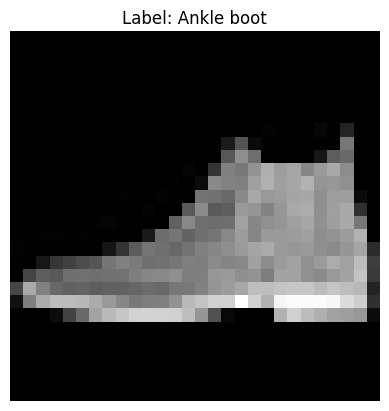

In [13]:
import matplotlib.pyplot as plt

# Get the first image and its label
img, label = test_data[0]

# Squeeze the channel dimension if it's 1, and convert to numpy for displaying
img_np = img.squeeze().numpy()

# Display the image
plt.imshow(img_np, cmap="gray")
plt.title(f"Label: {classes[label]}")
plt.axis("off")
plt.show()

# **Tensors**

In [14]:
import torch
import numpy as np

In [15]:
data = [[1,2], [3,4]]
x_data = torch.tensor(data)

In [16]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

In [17]:
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.3724, 0.9391],
        [0.1835, 0.6105]]) 



In [18]:
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.0462, 0.6999, 0.8840],
        [0.1371, 0.4622, 0.4303]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [19]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")
print(f"tensor is : {tensor}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu
tensor is : tensor([[0.7458, 0.7971, 0.1779, 0.7758],
        [0.4056, 0.5596, 0.0928, 0.0491],
        [0.3760, 0.1168, 0.7072, 0.3548]])


In [20]:
# We move our tensor to the current accelerator if available
if torch.accelerator.is_available():
    tensor = tensor.to(torch.accelerator.current_accelerator())

In [21]:
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:,1] = 0
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [22]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


In [23]:
t1 = torch.stack([tensor, tensor, tensor], dim=1)
print(t1)

tensor([[[1., 0., 1., 1.],
         [1., 0., 1., 1.],
         [1., 0., 1., 1.]],

        [[1., 0., 1., 1.],
         [1., 0., 1., 1.],
         [1., 0., 1., 1.]],

        [[1., 0., 1., 1.],
         [1., 0., 1., 1.],
         [1., 0., 1., 1.]],

        [[1., 0., 1., 1.],
         [1., 0., 1., 1.],
         [1., 0., 1., 1.]]])


In [24]:
# This computes the matrix multiplication between two tensors. y1, y2, y3 will have the same value
# ``tensor.T`` returns the transpose of a tensor
print(tensor)
y1 = tensor @ tensor.T
print(y1)
y2 = tensor.matmul(tensor.T)
print(y2)
y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)
print(y3)


# This computes the element-wise product. z1, z2, z3 will have the same value
z1 = tensor * tensor
print(z1)
z2 = tensor.mul(tensor)
#print(z2)
z3 = torch.rand_like(tensor)
#torch.mul(tensor, tensor, out=z3)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])
tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])
tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [25]:
agg = tensor.sum()
agg_item = agg.item()
print(agg)
print(agg_item, type(agg_item))

tensor(12.)
12.0 <class 'float'>


In [26]:
print(f"{tensor} \n")
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


In [27]:
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]


# **Datasets/Dataloaders**

48223
55647
27989
43524
5362
43738
58201
17913
35612


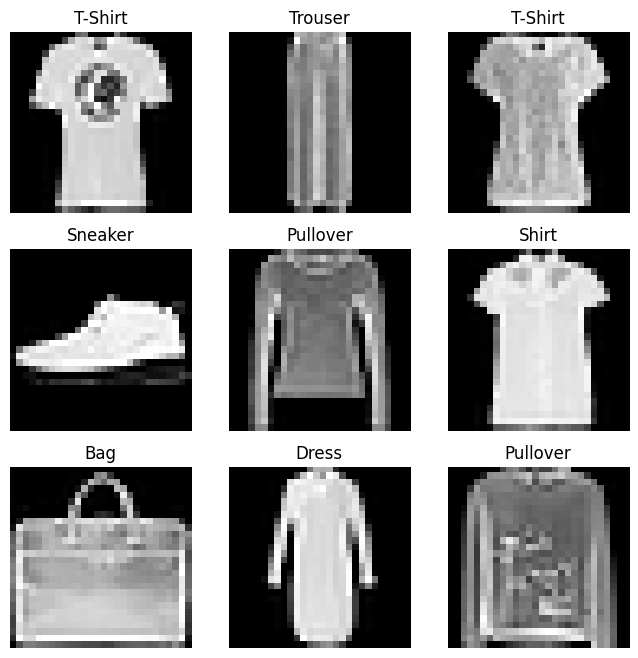

In [28]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    print(sample_idx)
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [29]:
import os
import pandas as pd
from torchvision.io import decode_image
from torch.utils.data import Dataset # Added this line

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [30]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


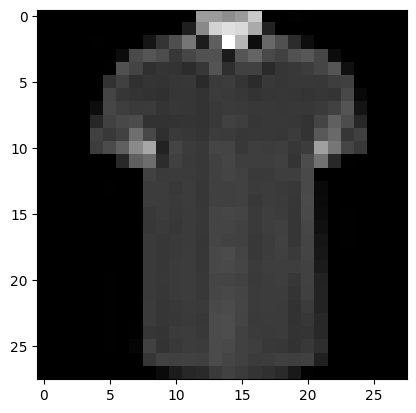

Label: 6


In [31]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# **Transforms**

In [32]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

# **Build the NN**

In [33]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([8])


In [34]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


In [35]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


In [36]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


In [37]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[-2.3013e-01, -3.0758e-01,  7.2443e-02, -2.8488e-01, -1.2611e-01,
          3.5859e-01, -3.0410e-01, -1.7666e-01,  8.1848e-04, -1.0050e+00,
         -1.9961e-01,  1.5371e-01, -3.7852e-01, -1.0362e-01,  2.6074e-01,
          2.1253e-01, -3.9747e-01, -1.0394e-01,  4.4124e-01, -3.0269e-02],
        [-5.5662e-02,  1.1218e-01,  1.8811e-01, -4.8167e-01, -4.5387e-01,
          1.9618e-01,  1.2239e-01,  2.1356e-01, -3.9397e-01, -3.4053e-01,
          1.6614e-01, -5.3194e-01, -2.2530e-01, -2.2722e-01,  3.8879e-01,
         -7.7608e-02, -6.3546e-01, -5.2812e-01,  5.1815e-01,  5.9892e-02],
        [-1.9521e-01, -8.7743e-02,  8.0218e-02, -7.5569e-01,  1.4344e-01,
          4.1632e-01,  5.8149e-02, -4.6733e-02,  1.3613e-01, -6.4356e-01,
         -1.5412e-01, -3.6430e-01, -1.7189e-01, -4.2238e-01,  3.4097e-01,
          3.1460e-01, -4.3158e-01, -1.1317e-01,  7.5024e-01,  1.1458e-01]],
       grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.0000, 0.0724, 0.0000, 0.0000,

In [38]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

In [39]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

In [40]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0336,  0.0111, -0.0070,  ...,  0.0036,  0.0151,  0.0011],
        [ 0.0239, -0.0237,  0.0030,  ...,  0.0280, -0.0299, -0.0185]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0123,  0.0082], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0156,  0.0434, -0.0362,  ...,  0.0462,  0.0022,  0.0125],
        [ 0.0042,  0.0288, -0.0192,  ..., -0.0266,  0.0432,  0.0322]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

In [41]:
print("Model Parameters:")
print("------------------")

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name}")
        print(f"  Size: {param.size()}")
        # Print a snippet of the values to avoid excessive output
        print(f"  Values (first 10 elements if available): {param.data.flatten()[:10]}\n")


Model Parameters:
------------------
Layer: linear_relu_stack.0.weight
  Size: torch.Size([512, 784])
  Values (first 10 elements if available): tensor([-0.0336,  0.0111, -0.0070, -0.0331, -0.0032,  0.0031,  0.0317, -0.0056,
         0.0199,  0.0048])

Layer: linear_relu_stack.0.bias
  Size: torch.Size([512])
  Values (first 10 elements if available): tensor([-0.0123,  0.0082,  0.0348,  0.0209,  0.0258, -0.0059, -0.0336, -0.0349,
         0.0114, -0.0463])

Layer: linear_relu_stack.2.weight
  Size: torch.Size([512, 512])
  Values (first 10 elements if available): tensor([ 0.0156,  0.0434, -0.0362, -0.0351, -0.0374,  0.0360, -0.0350, -0.0421,
         0.0434,  0.0080])

Layer: linear_relu_stack.2.bias
  Size: torch.Size([512])
  Values (first 10 elements if available): tensor([ 0.0681,  0.0734,  0.0909, -0.0102, -0.0050, -0.0286, -0.0222,  0.0513,
         0.0037,  0.0892])

Layer: linear_relu_stack.4.weight
  Size: torch.Size([10, 512])
  Values (first 10 elements if available): tensor

In [42]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [43]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x790a915306a0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x790aacd98490>


In [44]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.0137, 0.2341, 0.0712],
        [0.0137, 0.2341, 0.0712],
        [0.0137, 0.2341, 0.0712],
        [0.0137, 0.2341, 0.0712],
        [0.0137, 0.2341, 0.0712]])
tensor([0.0137, 0.2341, 0.0712])


In [45]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

True
False
False


# **Optimizing Model Parameters**

# **Save and Load the Model**

In [46]:
torch.save(model, 'model.pth')
model = torch.load('model.pth', weights_only=False)